# P-Value

### History of p-value
   The p-value was created to determine whether something is worth further investigation. Ronald Fisher popularised the p-value by devising a method known as "significance testing," which he used to draw assumptions based on the evidence in the data. Eight years later, two additional statisticians, Neyman and Pearson, developed “hypothesis testing,” which believed that no research could give proof for any single hypothesis and instead focused on reducing the number of incorrect conclusions. These two distinct concepts are frequently misconstrued, and it is worthwhile to learn more about them.

### What is p-value?
The **p-value**, often known as the probability value, indicates how likely it is that your data occurred under the null hypothesis. It accomplishes this by determining the likelihood of your test statistic, which is a value computed from your data via a statistical test.

>**Null hypothesis** is a generic statement that tells us two measurable phenomena do not have any connection.

If the null hypothesis of your statistical test was true, the p-value informs you how often you'd expect to see a test statistic as extreme as or more extreme than the one determined by your statistical test. As the test statistic generated from your data moves further away from the range of sample statistics anticipated by the null hypothesis, the p-value decreases.

### **How does a P-Value help in a machine learning model?**
The p-value for the dataset will change depending on whatever features are removed from the dataset. In each scenario, we can delete distinct attributes and calculate the p-value. These calculated p-values can be used to determine whether or not to preserve a feature.

>Lets look at an example where we will implement p-value for feature selection.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

np.random.seed(123)
import warnings
warnings.filterwarnings("ignore")

### Dataset
The dataset we will be using is [Breast Cancer Data Set](https://drive.google.com/file/d/1fh5hT4ECPW7ElfgzUdURtSXQEYx0PKid/view?usp=sharing).

In [2]:
data = pd.read_csv('breast_cancer.csv')

In [3]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
data = data.iloc[:,1:-1]

Let's encode dtype 'Object' to 'float' for performing calculations

In [5]:
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [6]:
# looking at the feature information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null float64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 

In [7]:
corr = data.corr()
corr.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,-0.012838,0.567134,-0.008303,0.556141,0.548236,-0.067016,0.292999,0.253730,0.408042,-0.006522,0.077972,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738


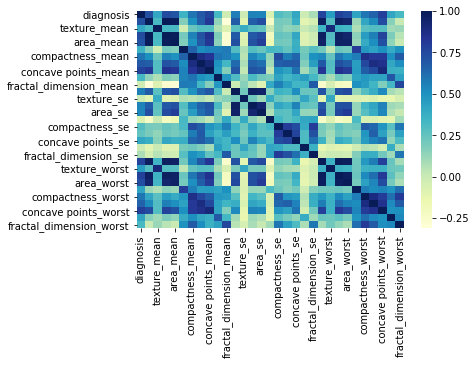

In [8]:
sns.heatmap(corr, cmap = 'YlGnBu')

In [9]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [10]:
selected_columns = data.columns[columns]
selected_columns.shape

(21,)

In [11]:
data = data[selected_columns]

In [12]:
# eliminating the dignosis column
selected_columns = selected_columns[1:].values         

### Implementing p-value for feature selection

In [13]:
import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [14]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.iloc[:,1:].values, data.iloc[:,0].values, SL, selected_columns)

In [15]:
result = pd.DataFrame()
result['diagnosis'] = data.iloc[:,0]

In [16]:
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

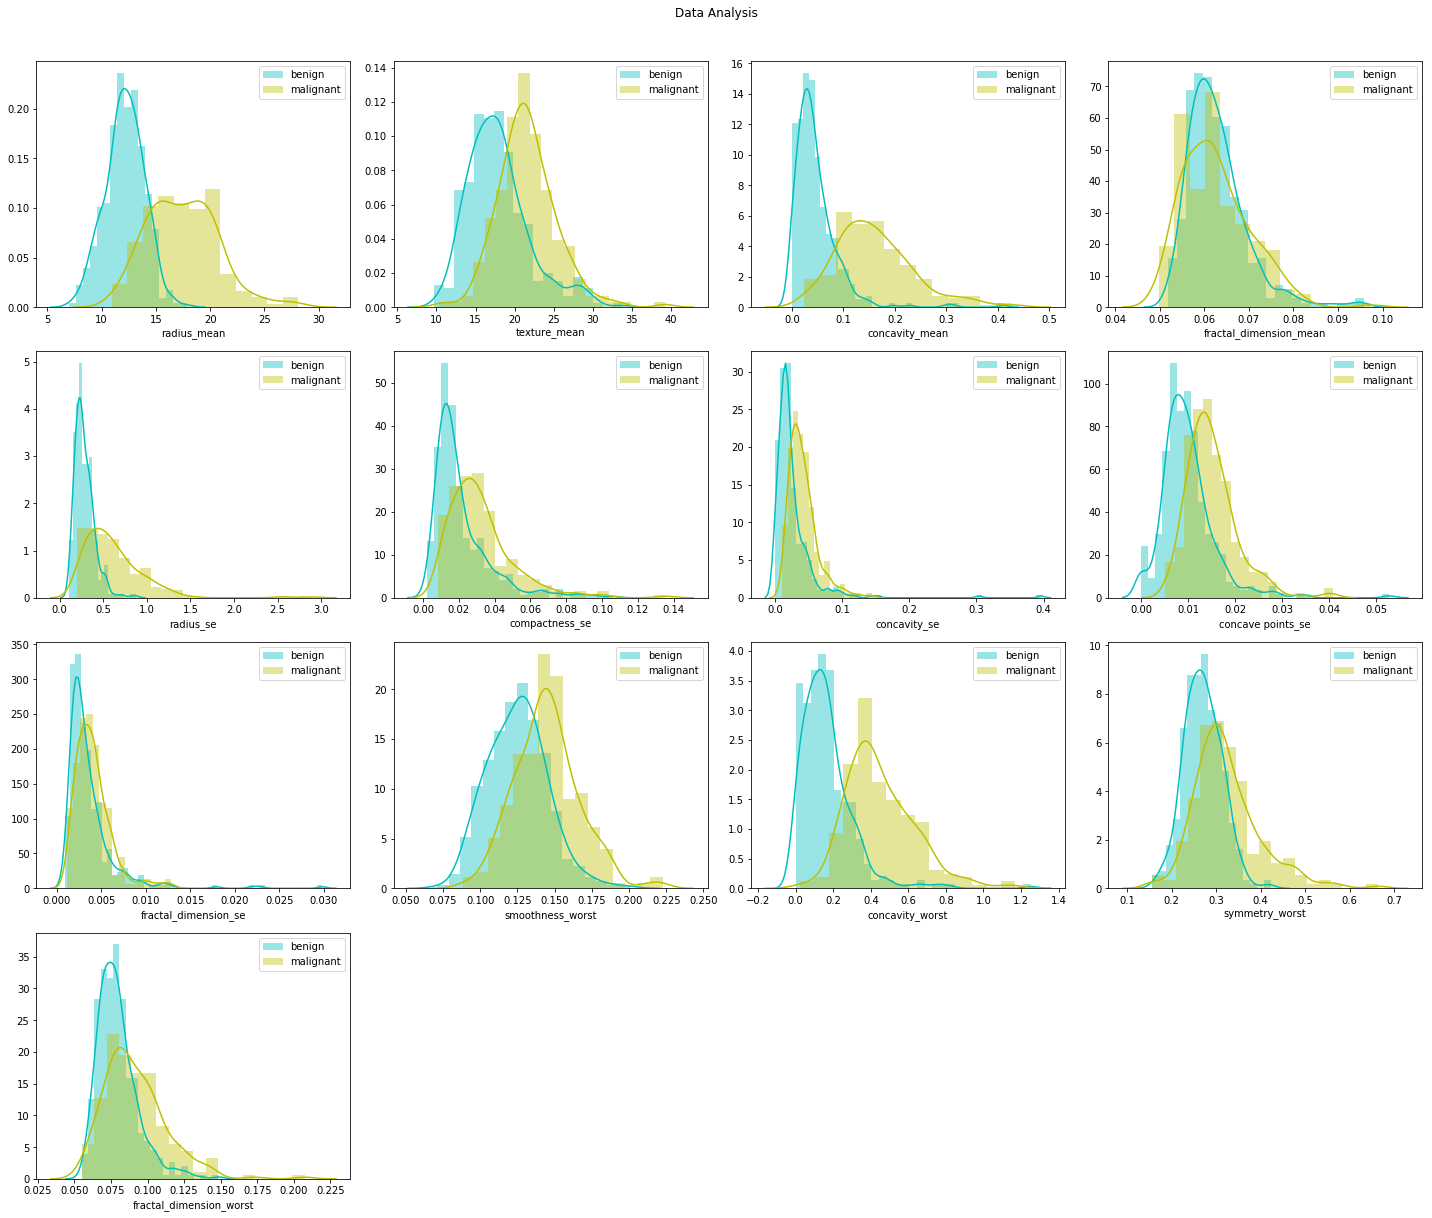

In [17]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(data[i][result['diagnosis']==0], color='c', label = 'benign')
    sns.distplot(data[i][result['diagnosis']==1], color='y', label = 'malignant')
    plt.legend(loc='best')
fig.suptitle('Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Splitting data into train and test

In [18]:
x_train, x_test, y_train, y_test = train_test_split(data.values, result.values, test_size = 0.2)

Implementing the Support Vector Classifier

Note: SVC uses gaussian kernal by default

In [19]:
svc = SVC(random_state=1)
svc.fit(x_train, y_train)
prediction = svc.predict(x_test)

In [20]:
cm = confusion_matrix(y_test, prediction)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/x_test.shape[0]
print("Confusion Matrix with feature selection:\n",cm)

Confusion Matrix with feature selection:
 [[73  0]
 [ 8 33]]


In [21]:
print("Accuracy of the model with feature selection is: ",accuracy*100)

Accuracy of the model with feature selection is:  92.98245614035088


In [22]:
data = pd.read_csv('breast_cancer.csv')          
result = pd.DataFrame()
result['diagnosis'] = data.iloc[:,1]
data = data.iloc[:,2:-1]                         
label_encoder = LabelEncoder()              
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')    
x_train, x_test, y_train, y_test = train_test_split(data.values, result.values, test_size = 0.2)      
svc = SVC(random_state=1)
svc.fit(x_train, y_train)                        
prediction = svc.predict(x_test)                 
cm = confusion_matrix(y_test, prediction)        
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/x_test.shape[0]                
print("Confusion Matrix without feature selection:\n",cm)

Confusion Matrix without feature selection:
 [[71  0]
 [43  0]]


In [23]:
print("Accuracy of the model without feature selection is: ",accuracy*100)

Accuracy of the model without feature selection is:  62.28070175438597


#### As you can notice we get proper accuracy only when you perform proper feature engineering

### Some general misunderstandings about the p-value
The p-value indicates the probability of getting these results if the mean or expected value is right or true. As a consequence, it informs you how effective your test is at detecting unexpected results. It does not, however, inform you whether your sample is genuinely different from what would be predicted by chance based on the test statistics.

### Key things to keep in mind while using p-value.

P-values are frequently understood as the probability of rejecting the null hypothesis of a test when it is actually true.
In actuality, especially looking at a single study or utilising small sample sizes, the risk of rejecting the null hypothesis is generally higher than the p-value. This is due to the fact that the shorter your frame of reference, the more likely you are to discover a statistically significant pattern by chance.
P-values are frequently used to support or refute an alternate hypothesis. This isn't the case at all. The p-value can only tell you if the null hypothesis is true or false. It cannot tell you whether your alternative hypothesis is true